In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from k2 import K2Processor
from evaluation import extract_params, spawn_model

In [4]:
import utils
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import networkx as nx
import os

In [5]:
test_df = pd.read_csv('../data/results/K2_test_results.csv', index_col=0)

In [6]:
filt = test_df[(test_df.encoder == 'COLLAPSE') & (test_df.metric == 'precision') & (test_df.regime == 'class-1')].sort_values('value', ascending=False)
filt.head(20)

,encoder,model,threshold,datum_id,regime,metric,value
291,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,1wepA.pkl,class-1,precision,1.0
1361,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,3hphD.pkl,class-1,precision,1.0
321,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,5exhC.pkl,class-1,precision,1.0
1354,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,1xjsA.pkl,class-1,precision,1.0
1325,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,4m3oB.pkl,class-1,precision,1.0
1005,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,1p91B.pkl,class-1,precision,1.0
378,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,2lv9A.pkl,class-1,precision,1.0
731,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,1d0qA.pkl,class-1,precision,1.0
1035,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,1wurB.pkl,class-1,precision,1.0
1240,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,2orwA.pkl,class-1,precision,1.0


<Axes: >

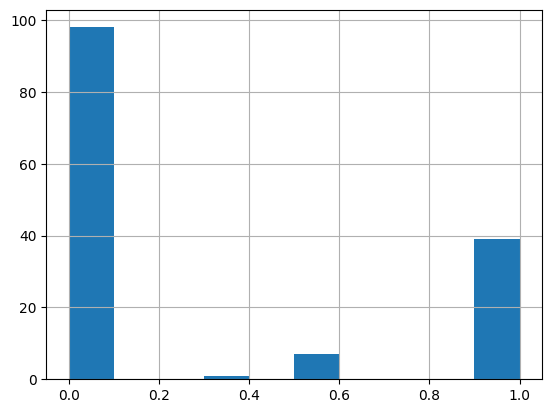

In [7]:
filt.value.hist()

In [8]:
high_precision = filt[filt.value > 0.5]

In [9]:
metal = 'ZN'
encoder = 'COLLAPSE'
model_str = 'k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model'
k,r,cutoff,alpha,tau,lam = extract_params(model_str)

processor_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results_2/{encoder}-fitted_k2_processors"
model_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results_2/{encoder}-fitted_k2_models"
# G_test_dir = f"../data/{encoder}_{metal}_cutoff_test_graphs_2"
# G_train_dir = f"../data/{encoder}_{metal}_cutoff_train_graphs_2"
G_dir = f"../data/{encoder}_{metal}_{cutoff}_test_graphs_2"

# model_str = "k25_r4_cutoff6.00_alphanan_taunan_lam0.50.model" #using the best r>0 model for viz


In [5]:
def create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein"):
    k,r,cutoff,alpha,tau,lam = extract_params(model_str)
    processor_name = "k%d_cutoff%.2f.processor" % (k, cutoff)
    G_dir = G_dir.replace('cutoff', '%.1f'%cutoff)

    proc = utils.deserialize_model(os.path.join(processor_cache_dir, processor_name))
    model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))

    G_path = G_dir + "/" + G_id + ".pkl"
    G = utils.deserialize(G_path)
    sprite = utils.construct_sprite(G, proc)
    P = model.prospect(G)
    print('visualizing motif graph...')
    kernel_map = model.visualize_motif_graph(G)
    
    if datatype=='protein':
        print('visualizing sprite...')
        sprite_viz = utils.visualize_protein_sprite(sprite)
        print('visualizing prospect map...')
        prospect_map = utils.visualize_protein_sprite(P, prospect_flag=True)
        print('visualizing ground truth...')
        gt = utils.visualize_protein_sprite(utils.set_graph_emb(G, 'gt'), gt_flag=True)
    elif datatype=="image":
        sprite_map = utils.convert_graph2arr(sprite)
        sprite_viz = utils.visualize_quantizedZ(sprite_map)
        prospect_map = model.visualize_prospect_map(P)
        gt = model.visualize_prospect_map(P, gt_flag=True)

    return kernel_map, sprite_viz, prospect_map, gt

No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling


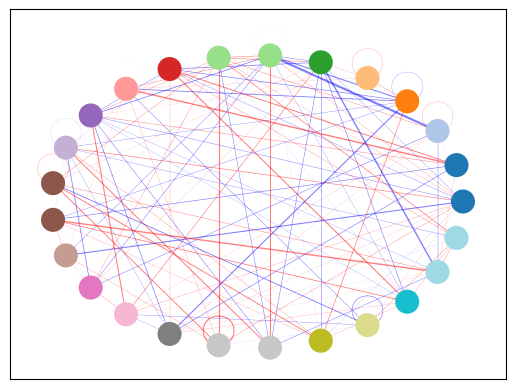

In [6]:
model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))
model.visualize_motif_graph()

visualizing motif graph...
Displaying motif graph with log10 scaling
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 4.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 4.0, 2.0, 0.0, 0.0, 8.0, 0.0, 6.0, 0.0, 0.0, 29.0, 2.0, 0.0, 2.0, 4.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 2.0, 14.0, 0.0, 2.0, 16.0, 12.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 23.0, 0.0, 6.0, 0.0, 6.0, 6.0, 0.0, 4.0, 0.0, 0.0, 2.0, 6.0, 0.0, 0.0, 2.0, 6.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 6.0, 6.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 4.0, 4.0, 8.0, 0.0, 12.0, 2.0, 0.0, 24.0, 48.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 2.0, 2.0, 0.0, 0.0, 6.0, 0.0, 0.0, 3.0, 4.0, 18.0, 2.0, 10.0, 0.0, 0.0, 8.0, 0.0, 12.0, 4.0, 30.0, 0.0, 8.0, 0.0, 14.0, 0.0, 0.0, 30.0, 0.0, 4.0, 0.0, 0.0, 0.0, 14.0, 0.0, 6.0, 0.0, 0.0, 0

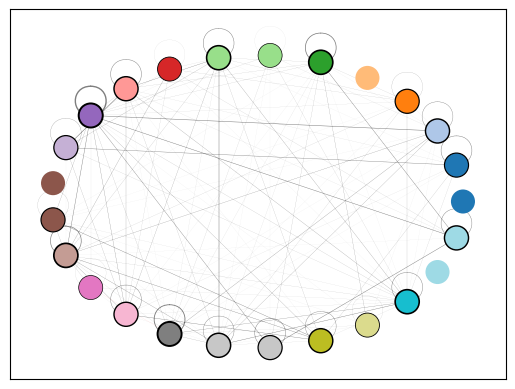

In [175]:
G_id = "2eg4A"
kernel_map, sprite_viz, prospect_map, gt = create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein")

In [126]:
import time
def save_image(view, fname):
    img = view.render_image()
    
    while not img.value:
        time.sleep(0.1)
    
    with open(f"{fname}.png", "wb") as f:
        f.write(img.value)

In [ ]:
save_image(sprite_viz, f'{G_id}_sprite')

In [161]:
sprite_viz

NGLWidget()

In [162]:
prospect_map

NGLWidget()

In [163]:
# show_residues_around(gt, "ZN")
# gt.center("ZN")
gt

NGLWidget()

In [122]:
sprite_viz.render_image(trim=True, factor=2)

Image(value=b'', width='99%')

In [10]:
from tqdm import tqdm
def linearized_kernel(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein"):
    k,r,cutoff,alpha,tau,lam = extract_params(model_str)
    processor_name = "k%d_cutoff%.2f.processor" % (k, cutoff)
    G_dir = G_dir.replace('cutoff', '%.1f'%cutoff)

    proc = utils.deserialize_model(os.path.join(processor_cache_dir, processor_name))
    model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))

    G_path = G_dir + "/" + G_id + ".pkl"
    G = utils.deserialize(G_path)
    sprite = utils.construct_sprite(G, proc)
    P = model.prospect(G)

    kernel_map = model.motif_graph_weight(sprite)
    n_weights = list(nx.get_node_attributes(kernel_map, 'n_weight').values())
    e_weights = list(nx.get_edge_attributes(kernel_map, 'e_weight').values())
    lin_kernel = n_weights + e_weights

    return lin_kernel

In [11]:
kernel_arr = []
labels = []
for g_path in tqdm(high_precision.datum_id):
    G_id = g_path.strip('.pkl')
    kernel = linearized_kernel(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein")
    kernel_arr.append(kernel)
    labels.append(G_id)
kernel_arr = np.array(kernel_arr)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [01:18<00:00,  2.02s/it]


In [12]:
kernel_arr

array([[  6.,   0.,   0., ...,   0.,   4.,   0.],
       [ 33.,   7.,  11., ...,  14.,  35., 181.],
       [  0.,   0.,   0., ...,   0.,   1.,   0.],
       ...,
       [  9.,   0.,  16., ...,   2.,   7.,  39.],
       [ 24.,  14.,  32., ...,  32., 124.,  25.],
       [  3.,   0.,   0., ...,   0.,   2.,   0.]])

In [31]:
import seaborn as sns
def setup_figure(width=6, height=3):
    fig, ax = plt.subplots(figsize=(width,height))
    sns.set(style='white')
    sns.set_context('paper')
    return fig, ax
pal = sns.color_palette('tab20')

In [35]:
cmap = {2: 'gray', 3: 'orange', 4: 'red'}
colors = [cmap[x] for x in [3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 4, 2, 4, 4, 3, 2, 3, 3, 4, 2, 4, 2, 3, 2, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 3, 4, 4]]

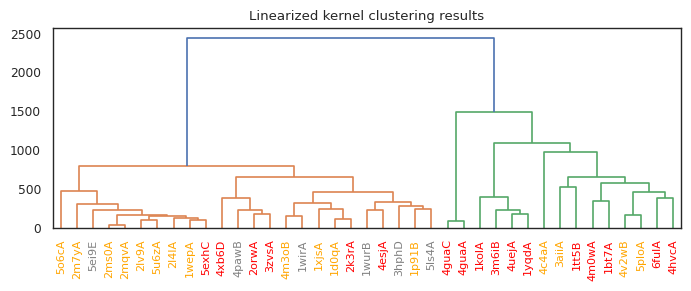

In [38]:
from scipy.cluster.hierarchy import dendrogram, linkage

fig, ax = setup_figure(7,3)
linkage_data = linkage(kernel_arr, method='ward', metric='euclidean')
dendrogram(linkage_data, labels=labels)
plt.title('Linearized kernel clustering results')
plt.xticks(rotation=90, ha='center')
[t.set_color(i) for (i,t) in
 zip(colors,ax.xaxis.get_ticklabels())]
plt.tight_layout()
plt.savefig("../data/figures/zn_clusters.png", dpi=300, format='png')
plt.show()